In [19]:
# importing required Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import joblib
from sqlalchemy import create_engine

In [ ]:
# Note:: The make sure you use the information from your specific PostgreSQL installation
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'apurba07' # this is the password established during installation
port = r'5432' # default port estabalished during install

In [21]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [22]:
table_name = r'mobile_cleaned'
schema = r'cleaned' # schema were the data was loaded last week.

df = pd.read_sql_table(table_name, db_conn, schema)

In [23]:
df.head(10)

,User_ID,Age,Gender,Total_App_Usage_Hours,Daily_Screen_Time_Hours,Number_of_Apps_Used,Social_Media_Usage_Hours,Productivity_App_Usage_Hours,Gaming_App_Usage_Hours,Location
0,1.0,56.0,male,2.61,7.15,24.0,4.43,0.55,2.40,los angeles
1,2.0,46.0,male,2.13,13.79,18.0,4.67,4.42,2.43,chicago
2,3.0,32.0,female,7.28,4.50,11.0,4.58,1.71,2.83,houston
3,8.0,40.0,male,9.53,8.85,11.0,2.66,0.28,2.93,chicago
4,10.0,28.0,male,1.80,4.11,16.0,2.14,1.20,0.96,new york
5,12.0,53.0,female,10.71,6.86,21.0,4.12,0.40,1.23,phoenix
6,13.0,57.0,female,1.91,7.15,4.0,0.73,0.74,4.57,los angeles
7,14.0,41.0,male,10.07,9.09,11.0,4.16,1.49,1.68,houston
8,16.0,39.0,male,4.54,6.82,17.0,4.22,4.55,2.67,new york
9,17.0,19.0,female,11.75,7.17,5.0,2.16,0.03,3.16,los angeles


In [24]:
# Drop unnecessary columns
drop_columns = ['User_ID', 'Location']
df = df.drop(columns=drop_columns, errors='ignore')

Removing columns that are not required for analysis.

In [25]:
# Convert categorical columns to numeric
df['Gender'] = df['Gender'].map({'male': 0, 'female': 1})

In [26]:
# Define first set of features and target
selected_features_1 = [
    "Age", "Total_App_Usage_Hours", "Daily_Screen_Time_Hours",
    "Number_of_Apps_Used", "Social_Media_Usage_Hours"
]
target = 'Productivity_App_Usage_Hours'  # Using productivity app usage as the target

selected_features_1: The first set of features for model training.

target: The dependent variable (what we are predicting).

In [27]:
# Split data into train, validation, and test sets
X1 = df[selected_features_1]
y = df[target]
X1_train, X1_temp, y1_train, y1_temp = train_test_split(X1, y, test_size=0.3, random_state=42)
X1_val, X1_test, y1_val, y1_test = train_test_split(X1_temp, y1_temp, test_size=0.5, random_state=42)

train_test_split: Splits the dataset into:

70% training data

30% temporary data (later split into validation and test sets)

Validation and test sets are further split into 15% validation and 15% test data.

In [28]:
# Initialize models for first feature set
models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "LinearRegression": LinearRegression(),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}
best_model = None
best_score = float('inf')

Defines three models:

RandomForestRegressor: An ensemble learning method.

LinearRegression: A simple regression model.

XGBoost: A gradient boosting method.

In [29]:
# Initialize variables to track the best model based on R² Score and MSE
best_model = None
best_r2 = float('-inf')  # Higher R² is better
best_mse = float('inf')  # Lower MSE is better

# Train and evaluate models for first feature set
for name, model in models.items():
    model.fit(X1_train, y1_train)  # Train the model
    y1_pred = model.predict(X1_val)  # Make predictions on the validation set
    
    mse = mean_squared_error(y1_val, y1_pred)
    r2 = r2_score(y1_val, y1_pred)
    
    print(f"{name} - MSE with first feature set: {mse}")
    print(f"{name} - R² Score with first feature set: {r2}")
    
    if r2 > best_r2 or (r2 == best_r2 and mse < best_mse):
        best_r2 = r2
        best_mse = mse
        best_model = model

print(f"Best model based on R² Score and MSE: {best_model}")
print(f"Best model's MSE: {best_mse}")
print(f"Best model's R² Score: {best_r2}")


RandomForest - MSE with first feature set: 2.2497187787096773
RandomForest - R² Score with first feature set: 0.02595484141271953
LinearRegression - MSE with first feature set: 2.3075910323911812
LinearRegression - R² Score with first feature set: 0.0008982925460496727
XGBoost - MSE with first feature set: 2.6394966921557197
XGBoost - R² Score with first feature set: -0.1428046022605578
Best model based on R² Score and MSE: RandomForestRegressor(random_state=42)
Best model's MSE: 2.2497187787096773
Best model's R² Score: 0.02595484141271953


best_model: Stores the best-performing model.

best_score: Tracks the lowest mean squared error (MSE).

In [30]:
# Define second set of features
selected_features_2 = [
    "Age", "Gender", "Gaming_App_Usage_Hours", "Number_of_Apps_Used", "Total_App_Usage_Hours"
]


A different feature selection approach is used for comparison.

In [31]:
# Split data into train, validation, and test sets for second feature set
X2 = df[selected_features_2]
X2_train, X2_temp, y2_train, y2_temp = train_test_split(X2, y, test_size=0.3, random_state=42)
X2_val, X2_test, y2_val, y2_test = train_test_split(X2_temp, y2_temp, test_size=0.5, random_state=42)

In [32]:
# Save validation set to CSV
X2_val.to_csv("X2_val.csv", index=False)
y2_val.to_csv("Y2_val.csv", index=False)


In [33]:


# Train and evaluate models for second feature set
for name, model in models.items():
    model.fit(X2_train, y2_train)  # Train the model
    y2_pred = model.predict(X2_val)  # Make predictions on the validation set
    
    mse = mean_squared_error(y2_val, y2_pred)
    r2 = r2_score(y2_val, y2_pred)
    
    print(f"{name} - MSE with first feature set: {mse}")
    print(f"{name} - R² Score with first feature set: {r2}")
    
    if r2 > best_r2 or (r2 == best_r2 and mse < best_mse):
        best_r2 = r2
        best_mse = mse
        best_model = model

print(f"Best model based on R² Score and MSE: {best_model}")
print(f"Best model's MSE: {best_mse}")
print(f"Best model's R² Score: {best_r2}")


RandomForest - MSE with first feature set: 2.2537280141935487
RandomForest - R² Score with first feature set: 0.02421899049230314
LinearRegression - MSE with first feature set: 2.297579477242307
LinearRegression - R² Score with first feature set: 0.005232926241148128
XGBoost - MSE with first feature set: 2.6589381570328463
XGBoost - R² Score with first feature set: -0.15122203866132922
Best model based on R² Score and MSE: RandomForestRegressor(random_state=42)
Best model's MSE: 2.2497187787096773
Best model's R² Score: 0.02595484141271953


The first RandomForest model (with MSE 2.2497 and R² 0.0259) performs slightly better than the second RandomForest model (with MSE 2.2537 and R² 0.0242), as it has a marginally lower MSE and a slightly higher R² score. Both RandomForest models outperform LinearRegression and XGBoost in terms of both MSE and R² score. As a result, the best model in both scenarios is the RandomForestRegressor with the first feature set, which exhibits the lowest MSE and the highest R² score compared to the others.

In [34]:
#saving the best model
import joblib

joblib.dump(best_model, "best_model.pkl")
print("Best model saved successfully.")


Best model saved successfully.


In [35]:
table_name = r'features_cols'
schema = r'analytics' 

X2_val.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

93

In [36]:
table_name = r'targets_cols'
schema = r'analytics' 

y2_val.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

93

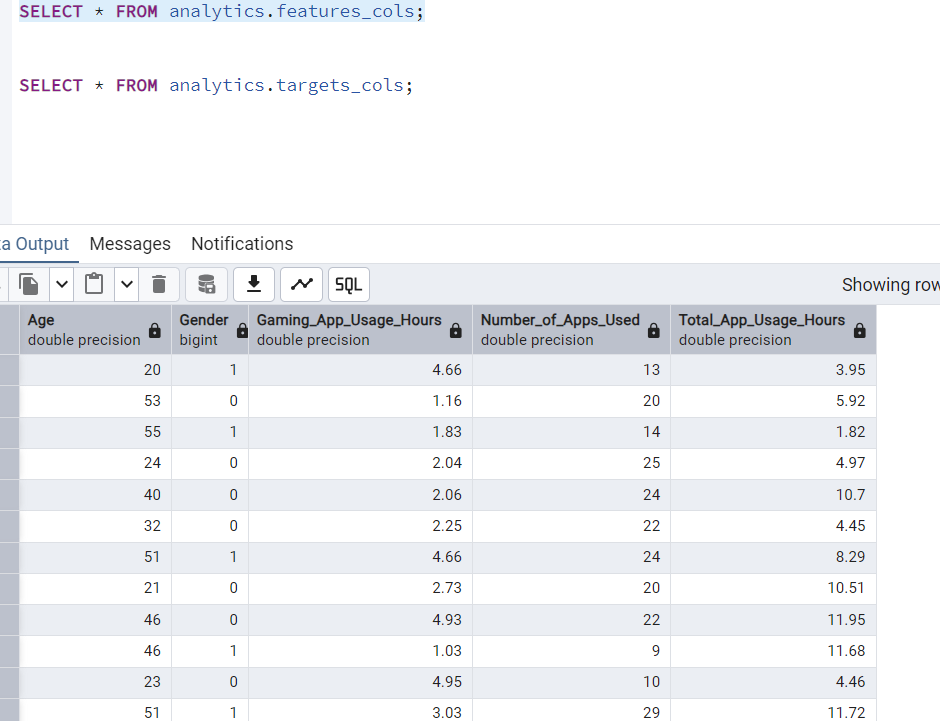

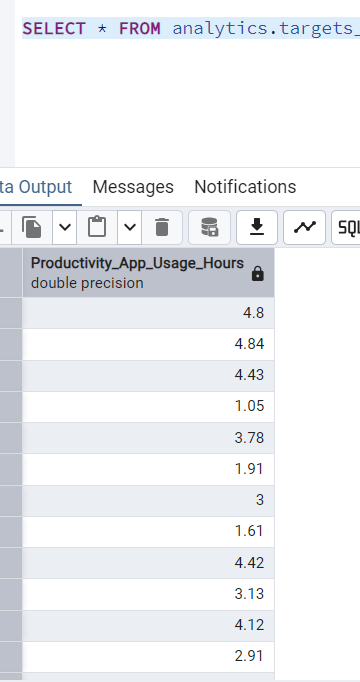